## Discrete-time competitive Beverton-Holt model

\begin{align}
N_{1,t+1}=\dfrac{r_1N_{1,t}}{1+a_{11}N_{1,t}+a_{12}N_{2,t}} \\
N_{2,t+1}=\dfrac{r_2N_{2,t}}{1+a_{22}N_{2,t}+a_{21}N_{1,t}}
\tag{1}
\end{align}

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import morris as morris_sampling
from SALib.analyze import morris as morris_analysis

from numba import jit
import pandas as pd

from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork') #grade3

In [2]:
seed=1234

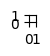

In [3]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

In [4]:
@jit(nopython=True)
def time_simul(y01,y02,r1,r2,a11,a22,a12,a21):
    tmax = 2
    y1 = np.zeros(tmax)
    y2 = np.zeros(tmax)
    per_cap1 = np.zeros(tmax)
    per_cap2 = np.zeros(tmax)
    y1_relat = np.zeros(tmax)
    y2_relat = np.zeros(tmax)
    y1[0],y2[0] = y01,y02 # initial conditions
    i,stopRun = 0,0
    while stopRun==0: # stops the simulation when the dynamics converges
        per_cap1[i] = r1 / ( 1 + a11 * y1[i] + a12 * y2[i] )
        per_cap2[i] = r2 / ( 1 + a22 * y2[i] + a21 * y1[i] )
        y1[i+1] = y1[i] * per_cap1[i]
        y2[i+1] = y2[i] * per_cap2[i]
        y1_relat[i]=y1[i]/(y1[i]+y2[i])
        y2_relat[i]=y2[i]/(y1[i]+y2[i])
        per_cap1=np.append(per_cap1,per_cap1[i])
        per_cap2=np.append(per_cap2,per_cap2[i])
        y1=np.append(y1,y1[i])
        y2=np.append(y2,y2[i])
        y1_relat=np.append(y1_relat,y1_relat[i])
        y2_relat=np.append(y2_relat,y2_relat[i])
        if np.abs(y1[i+1]-y1[i]) < 1.0e-3 and np.abs(y2[i+1]-y2[i]) < 1.0e-3:
            stopRun=1
        i+=1
        if i>1000:
            break
    return y1,y2, i

In [5]:
def CBHM(y01, y02, r1, r2, a11, a12, a21, a22):
    y1, y2, max_time = time_simul(y01, y02, r1, r2, a11, a22, a12, a21)
    return y1, y2, max_time

## Parameters

In [6]:
r1=15
r2=11
a11=0.7
a12=0.14
a22=0.1
a21=0.5

In [7]:
y01=5
y02=5
y0=[y01,y02]

## Sensitivity Analyses

### Species 1

In [8]:
from SALib.sample.morris import sample as ee_sample

# Parameter values
values_params = [
    r1,
    r2,
    a11,
    a12,
    a21,
    a22,
    y01,
    y02,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a11$",
    r"$a12$",
    r"$a21$",
    r"$a22$",
    r"$y01$",
    r"$y02$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [9]:
from tqdm import tqdm

t0 = 0
num_of_realizations = parameter_values.shape[0]

qoi_sensitivity_outputs = []

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    y1_final, y2_final, tf = CBHM(*parameters_realization)
    time_list_range = np.linspace(t0, tf, 100)
    num_of_time_list_points = time_list_range.shape[0]
    
    u_realization, v_realization = y1_final, y2_final
    
    qoi_sensitivity_outputs.append(u_realization[:num_of_time_list_points])

# Convert the list to a numpy array
qoi_sensitivity_outputs = np.array(qoi_sensitivity_outputs)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]

100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 39.36it/s]
/tmp/ipykernel_17043/4040687110.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qoi_sensitivity_outputs = np.array(qoi_sensitivity_outputs)


In [10]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time', *problem_info['names']])
df_zetai = pd.DataFrame(columns=['time', *problem_info['names']])  # Added new DataFrame to store zeta values

# Compute sensitivity indices for each time point
for time_point in tqdm(range(num_of_time_list_points)):
    qoi_sensitivity_outputs_time = np.array([y1_final[min(time_point, len(y1_final) - 1)] for y1_final in qoi_sensitivity_outputs])
    
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs_time, 
        num_levels=grid_level, 
        seed=seed
    )

    # Skip cases with no associated sensitivity indices
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    
    df_Si.loc[time_point, 'time'] = time_list_range[time_point]
    df_sigmai.loc[time_point, 'time'] = time_list_range[time_point]
    df_zetai.loc[time_point, 'time'] = time_list_range[time_point]  # Added this line to set the time value for df_zetai
    
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
        
        # Calculate and store zeta value
        zeta_value = np.sqrt(Si['mu_star_normalized'][idx]**2 + sigmai_normalized[idx]**2)
        df_zetai.loc[time_point, param_name] = zeta_value

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time', inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time', inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

# Added these lines to process df_zetai similarly to df_Si and df_sigmai
df_zetai.sort_values(by='time', inplace=True)
df_zetai.dropna(inplace=True)
df_zetai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time.values
df_zetai

  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_17043/229007541.py:24: RuntimeWarning: invalid value encountered in true_divide
  sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 363.86it/s]


,time,$r1$,$r2$,$a11$,$a12$,$a21$,$a22$,$y01$,$y02$
0,0.272727,0.286663,0.143377,0.60198,0.0,0.351193,0.065576,0.0,0.0
1,0.545455,0.222406,0.099336,0.70918,0.000352,0.38194,0.032452,0.00045,0.000782
2,0.818182,0.19073,0.079927,0.721304,0.000272,0.440255,0.021714,0.000438,0.00069
3,1.090909,0.177168,0.070756,0.7059,0.000228,0.507795,0.018186,0.000408,0.000626
4,1.363636,0.162278,0.062105,0.698784,0.000195,0.557862,0.016055,0.000371,0.000566
...,...,...,...,...,...,...,...,...,...
94,25.909091,0.013339,0.005521,1.010363,0.000048,0.383834,0.003877,0.000048,0.000073
95,26.181818,0.013339,0.005521,1.010363,0.000048,0.383834,0.003877,0.000048,0.000073
96,26.454545,0.013339,0.005521,1.010363,0.000048,0.383834,0.003877,0.000048,0.000073
97,26.727273,0.013339,0.005521,1.010363,0.000048,0.383834,0.003877,0.000048,0.000073


In [11]:
# Replace non-numeric values with NaN
df_zetai = df_zetai.applymap(lambda x: np.nan if x == '--' else x)

# Convert all columns to numeric
for col in df_zetai.columns:
    df_zetai[col] = pd.to_numeric(df_zetai[col], errors='coerce')

# Remove rows with NaN values
df_zetai.dropna(inplace=True)
# Drop the first row from df_zetai
df_zetai.drop(df_zetai.index[0], inplace=True)
# Reset the index
df_zetai.reset_index(drop=True, inplace=True)

# Check the results
# print(df_zetai.head())
# print(df_zetai.info())

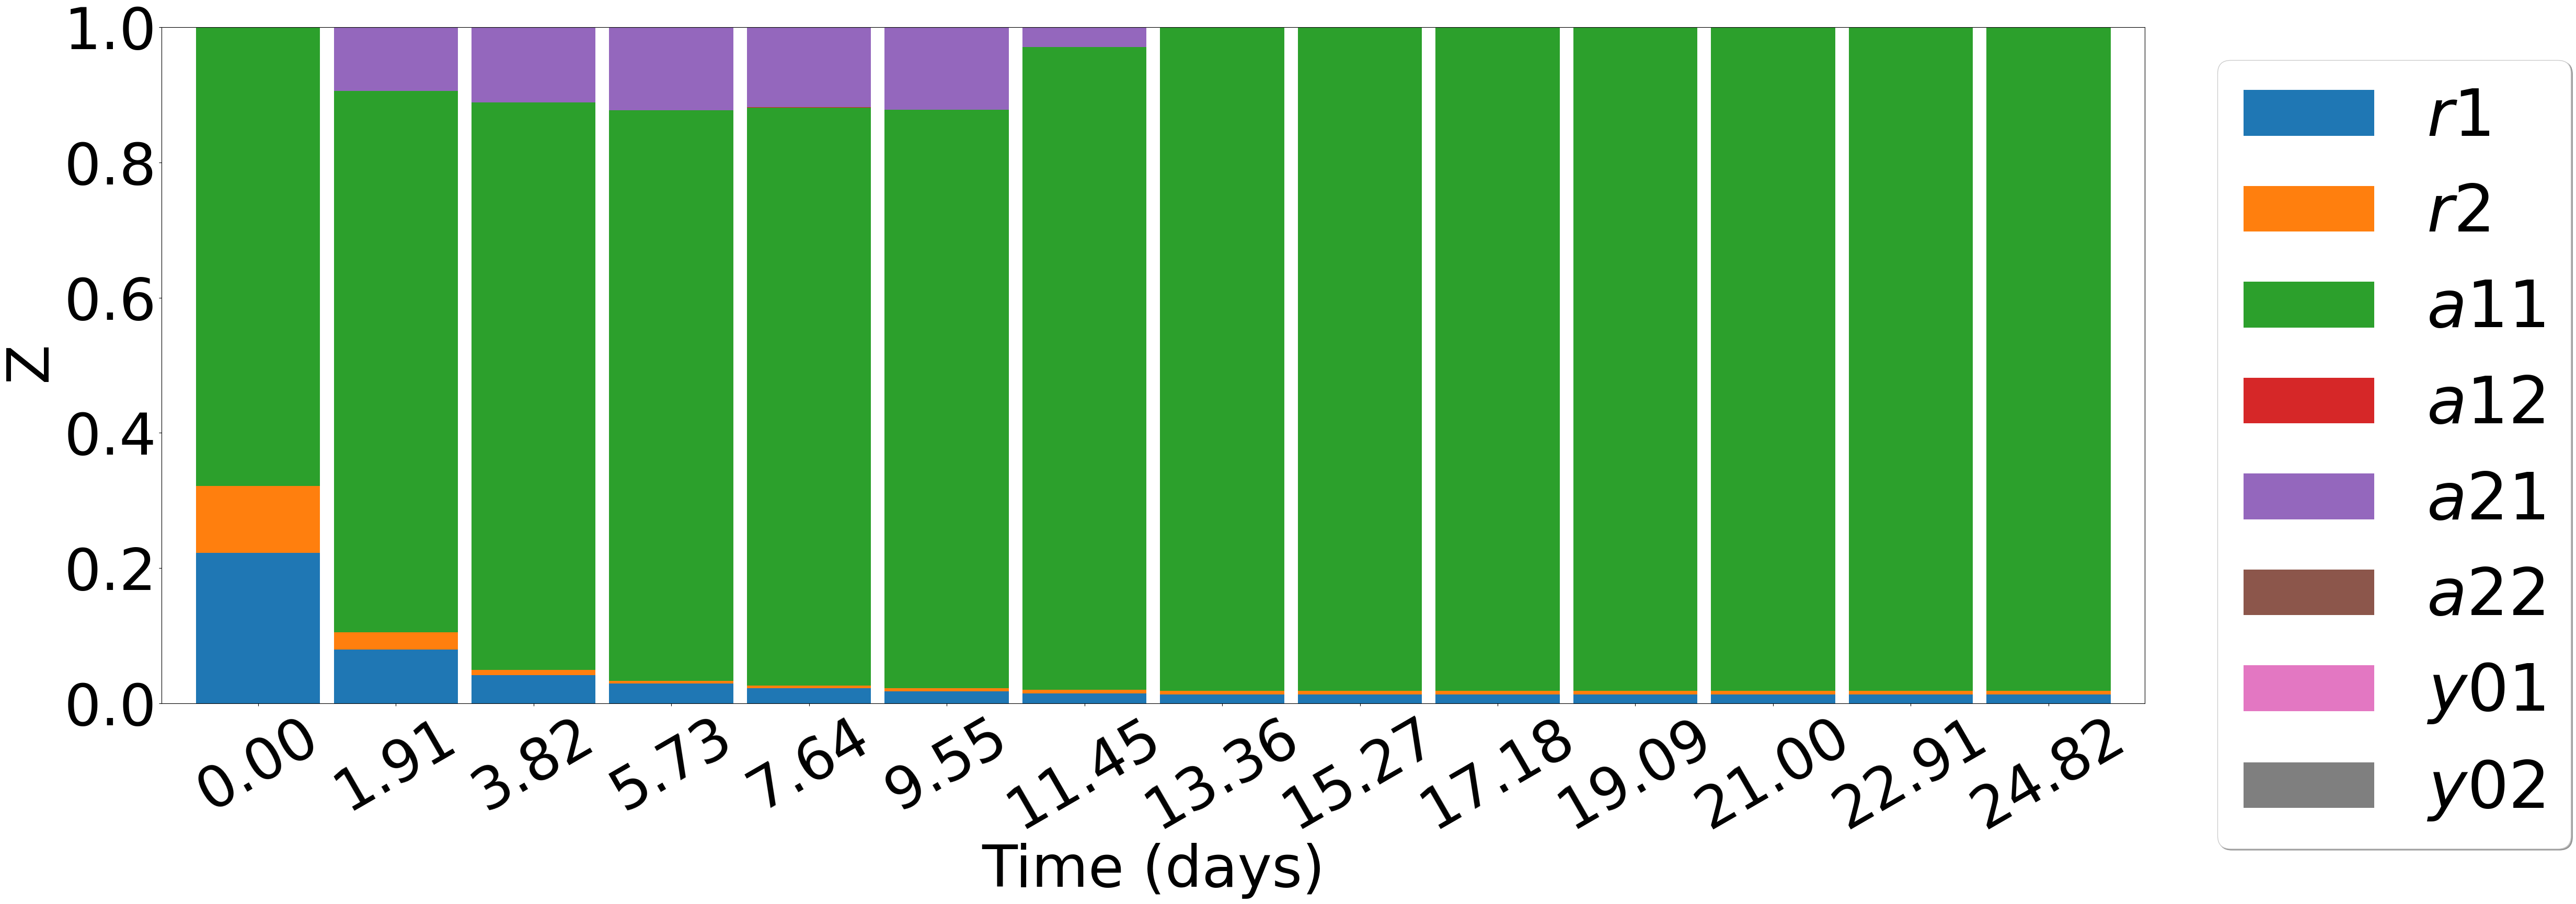

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 7
valid_time_lists_to_plot_zeta = valid_time_lists[::step_to_plot]
df_zetai[::step_to_plot].plot.bar(x='time', rot=30, width=0.9, figsize=(50, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_zeta[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 80), plt.ylabel("$\mathrm{Z}$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fancybox=True, shadow=True, fontsize=90) #ncol=len(problem_info['names']), 

plt.tight_layout()
plt.savefig("img/SA_species1_CBHM.png", dpi=50)
plt.show()

### Species 2

In [13]:
from tqdm import tqdm

t0 = 0
num_of_realizations = parameter_values.shape[0]

qoi_sensitivity_outputs = []

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    y1_final, y2_final, tf = CBHM(*parameters_realization)
    time_list_range = np.linspace(t0, tf, 100)
    num_of_time_list_points = time_list_range.shape[0]
    
    u_realization, v_realization = y1_final, y2_final

    # Calculate the frequency for species_2
    frequency_species_2 = v_realization / (u_realization + v_realization)
    
    qoi_sensitivity_outputs.append(frequency_species_2[:num_of_time_list_points])

# Convert the list to a numpy array
qoi_sensitivity_outputs = np.array(qoi_sensitivity_outputs)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]


100%|████████████████████████████████████████| 36/36 [00:00<00:00, 20191.89it/s]
/tmp/ipykernel_17043/2541220702.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qoi_sensitivity_outputs = np.array(qoi_sensitivity_outputs)


In [14]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time', *problem_info['names']])
df_zetai = pd.DataFrame(columns=['time', *problem_info['names']])  # Added new DataFrame to store zeta values

# Compute sensitivity indices for each time point
for time_point in tqdm(range(num_of_time_list_points)):
    qoi_sensitivity_outputs_time = np.array([y1_final[min(time_point, len(y1_final) - 1)] for y1_final in qoi_sensitivity_outputs])
    
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs_time, 
        num_levels=grid_level, 
        seed=seed
    )

    # Skip cases with no associated sensitivity indices
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    
    df_Si.loc[time_point, 'time'] = time_list_range[time_point]
    df_sigmai.loc[time_point, 'time'] = time_list_range[time_point]
    df_zetai.loc[time_point, 'time'] = time_list_range[time_point]  # Added this line to set the time value for df_zetai
    
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
        
        # Calculate and store zeta value
        zeta_value = np.sqrt(Si['mu_star_normalized'][idx]**2 + sigmai_normalized[idx]**2)
        df_zetai.loc[time_point, param_name] = zeta_value

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time', inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time', inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

# Added these lines to process df_zetai similarly to df_Si and df_sigmai
df_zetai.sort_values(by='time', inplace=True)
df_zetai.dropna(inplace=True)
df_zetai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time.values
df_zetai

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 365.99it/s]


,time,$r1$,$r2$,$a11$,$a12$,$a21$,$a22$,$y01$,$y02$
0,0.0,0.696429,0.718392,0.0,0.0,0.0,0.0,0.0,0.0
1,0.272727,0.212161,0.220373,0.272457,0.236187,0.139802,0.02831,0.124481,0.195075
2,0.545455,0.224287,0.193126,0.255784,0.317538,0.144583,0.016952,0.206318,0.062646
3,0.818182,0.251786,0.202515,0.164387,0.392497,0.137478,0.01194,0.249208,0.015439
4,1.090909,0.264158,0.209283,0.096187,0.439479,0.132816,0.009972,0.268341,0.003374
...,...,...,...,...,...,...,...,...,...
95,25.909091,0.266763,0.211264,0.030134,0.488371,0.129819,0.008884,0.27908,0.0
96,26.181818,0.266763,0.211264,0.030134,0.488371,0.129819,0.008884,0.27908,0.0
97,26.454545,0.266763,0.211264,0.030134,0.488371,0.129819,0.008884,0.27908,0.0
98,26.727273,0.266763,0.211264,0.030134,0.488371,0.129819,0.008884,0.27908,0.0


In [15]:
# Replace non-numeric values with NaN
df_zetai = df_zetai.applymap(lambda x: np.nan if x == '--' else x)

# Convert all columns to numeric
for col in df_zetai.columns:
    df_zetai[col] = pd.to_numeric(df_zetai[col], errors='coerce')

# Remove rows with NaN values
df_zetai.dropna(inplace=True)
# Drop the first row from df_zetai
df_zetai.drop(df_zetai.index[0], inplace=True)
# Reset the index
df_zetai.reset_index(drop=True, inplace=True)

# Check the results
# print(df_zetai.head())
# print(df_zetai.info())

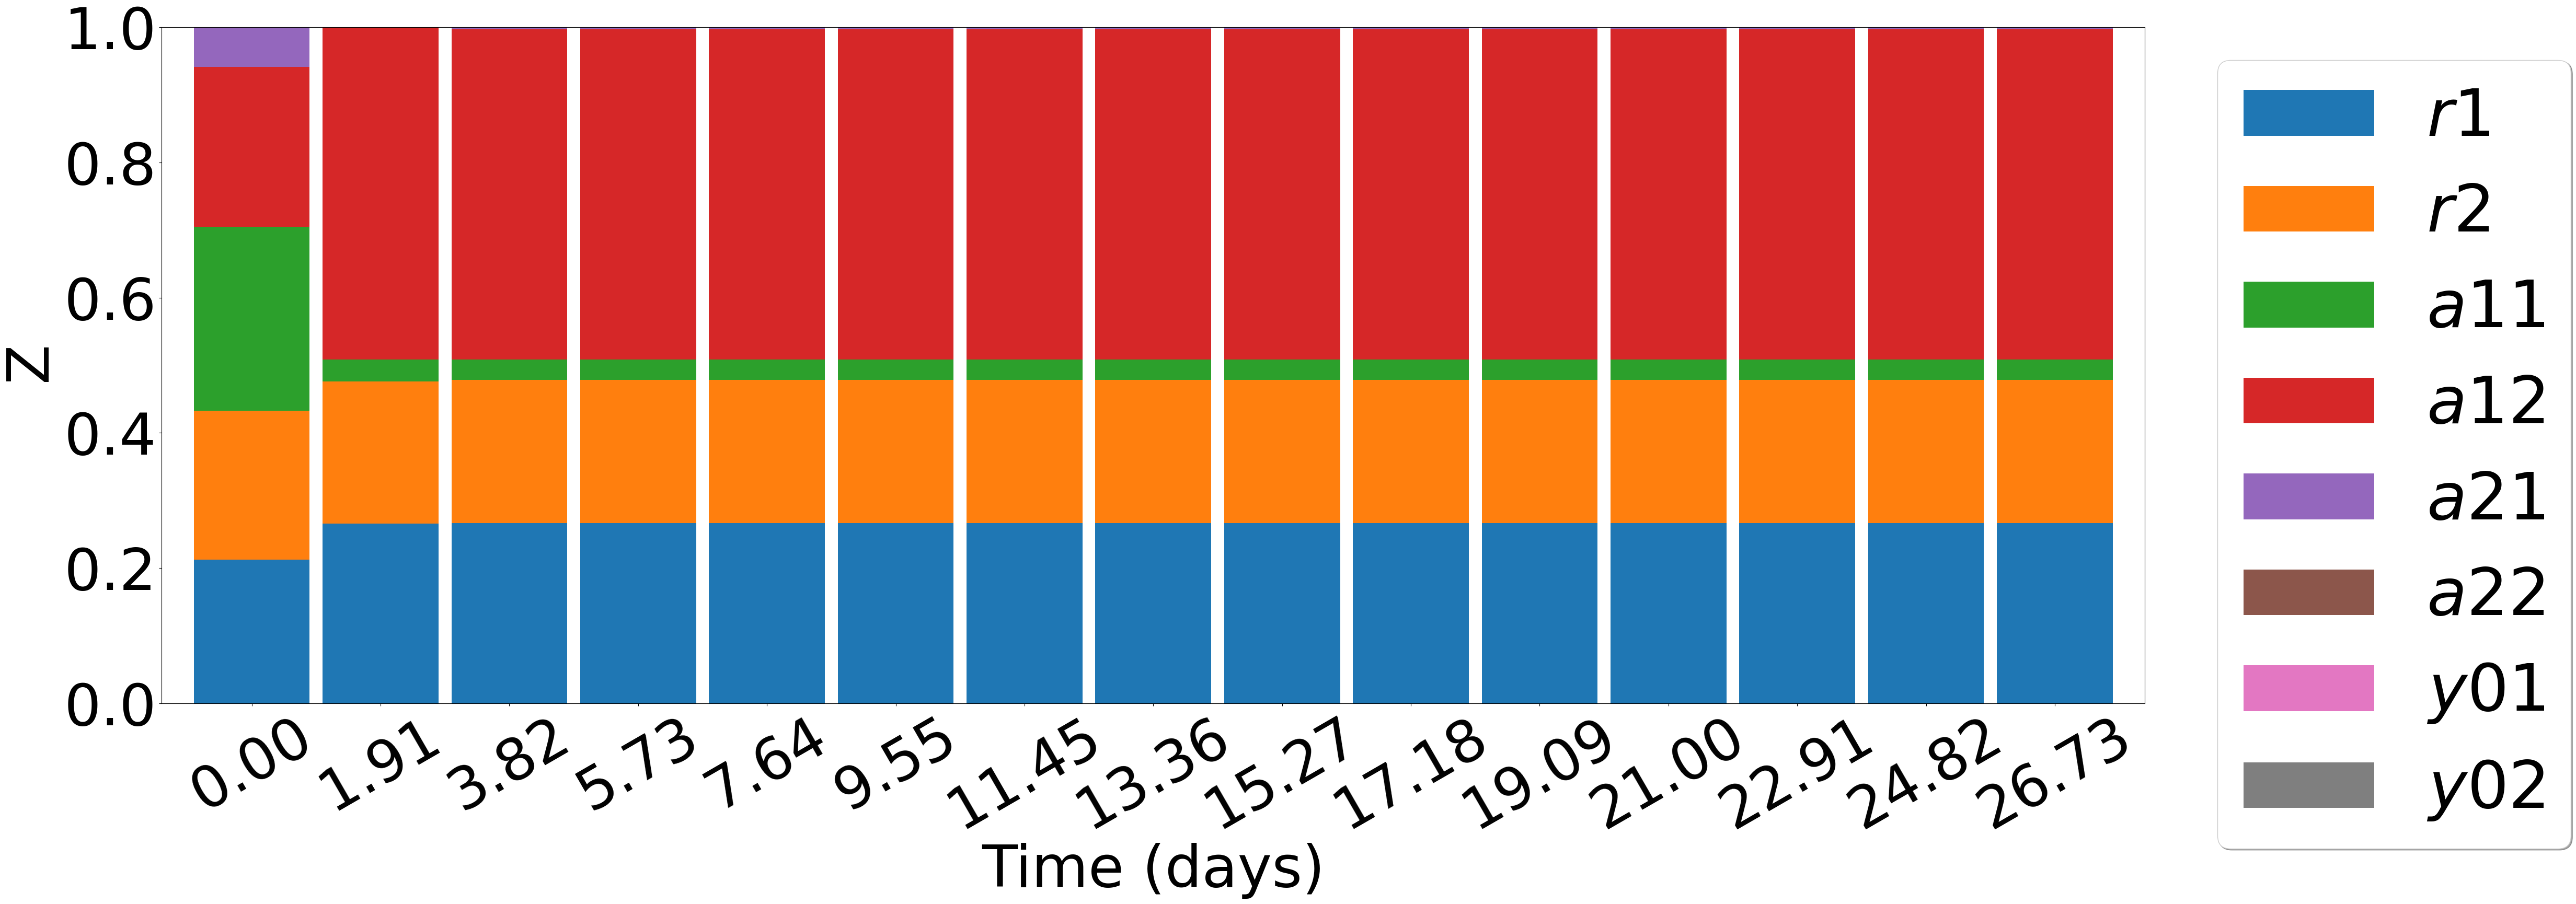

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 7
valid_time_lists_to_plot_zeta = valid_time_lists[::step_to_plot]
df_zetai[::step_to_plot].plot.bar(x='time', rot=30, width=0.9, figsize=(50, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_zeta[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 80), plt.ylabel("$\mathrm{Z}$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fancybox=True, shadow=True, fontsize=90) #ncol=len(problem_info['names']), 

plt.tight_layout()
plt.savefig("img/SA_species2_CBHM.png", dpi=50)
plt.show()

### Frequency

In [17]:
from tqdm import tqdm

t0 = 0
num_of_realizations = parameter_values.shape[0]

qoi_sensitivity_outputs = []

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    y1_final, y2_final, tf = CBHM(*parameters_realization)
    time_list_range = np.linspace(t0, tf, 100)
    num_of_time_list_points = time_list_range.shape[0]
    
    u_realization, v_realization = y1_final, y2_final
    
    qoi_sensitivity_outputs.append(v_realization[:num_of_time_list_points])

# Convert the list to a numpy array
qoi_sensitivity_outputs = np.array(qoi_sensitivity_outputs)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]

100%|████████████████████████████████████████| 36/36 [00:00<00:00, 20715.45it/s]
/tmp/ipykernel_17043/3683692340.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qoi_sensitivity_outputs = np.array(qoi_sensitivity_outputs)


In [18]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time', *problem_info['names']])
df_zetai = pd.DataFrame(columns=['time', *problem_info['names']])  # Added new DataFrame to store zeta values

# Compute sensitivity indices for each time point
for time_point in tqdm(range(num_of_time_list_points)):
    qoi_sensitivity_outputs_time = np.array([y1_final[min(time_point, len(y1_final) - 1)] for y1_final in qoi_sensitivity_outputs])
    
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs_time, 
        num_levels=grid_level, 
        seed=seed
    )

    # Skip cases with no associated sensitivity indices
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    
    df_Si.loc[time_point, 'time'] = time_list_range[time_point]
    df_sigmai.loc[time_point, 'time'] = time_list_range[time_point]
    df_zetai.loc[time_point, 'time'] = time_list_range[time_point]  # Added this line to set the time value for df_zetai
    
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
        
        # Calculate and store zeta value
        zeta_value = np.sqrt(Si['mu_star_normalized'][idx]**2 + sigmai_normalized[idx]**2)
        df_zetai.loc[time_point, param_name] = zeta_value

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time', inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time', inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

# Added these lines to process df_zetai similarly to df_Si and df_sigmai
df_zetai.sort_values(by='time', inplace=True)
df_zetai.dropna(inplace=True)
df_zetai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time.values
df_zetai

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 358.81it/s]


,time,$r1$,$r2$,$a11$,$a12$,$a21$,$a22$,$y01$,$y02$
0,0.0,0.0,1.414214,0.0,0.0,0.0,0.0,0.0,0.0
1,0.272727,0.203344,0.214972,0.0,0.346259,0.0,0.0,0.242516,0.443073
2,0.545455,0.171593,0.156485,0.166005,0.302749,0.093663,0.013267,0.310021,0.21657
3,0.818182,0.16517,0.151952,0.218455,0.347923,0.113953,0.011943,0.292052,0.118796
4,1.090909,0.177273,0.157817,0.218689,0.401683,0.110865,0.011245,0.277891,0.062951
...,...,...,...,...,...,...,...,...,...
95,25.909091,0.216352,0.175019,0.063671,0.522628,0.113918,0.012598,0.310335,0.0
96,26.181818,0.216352,0.175019,0.063671,0.522628,0.113918,0.012598,0.310335,0.0
97,26.454545,0.216352,0.175019,0.063671,0.522628,0.113918,0.012598,0.310335,0.0
98,26.727273,0.216352,0.175019,0.063671,0.522628,0.113918,0.012598,0.310335,0.0


In [19]:
# Replace non-numeric values with NaN
df_zetai = df_zetai.applymap(lambda x: np.nan if x == '--' else x)

# Convert all columns to numeric
for col in df_zetai.columns:
    df_zetai[col] = pd.to_numeric(df_zetai[col], errors='coerce')

# Remove rows with NaN values
df_zetai.dropna(inplace=True)
# Drop the first row from df_zetai
df_zetai.drop(df_zetai.index[0], inplace=True)
# Reset the index
df_zetai.reset_index(drop=True, inplace=True)

# Check the results
# print(df_zetai.head())
# print(df_zetai.info())

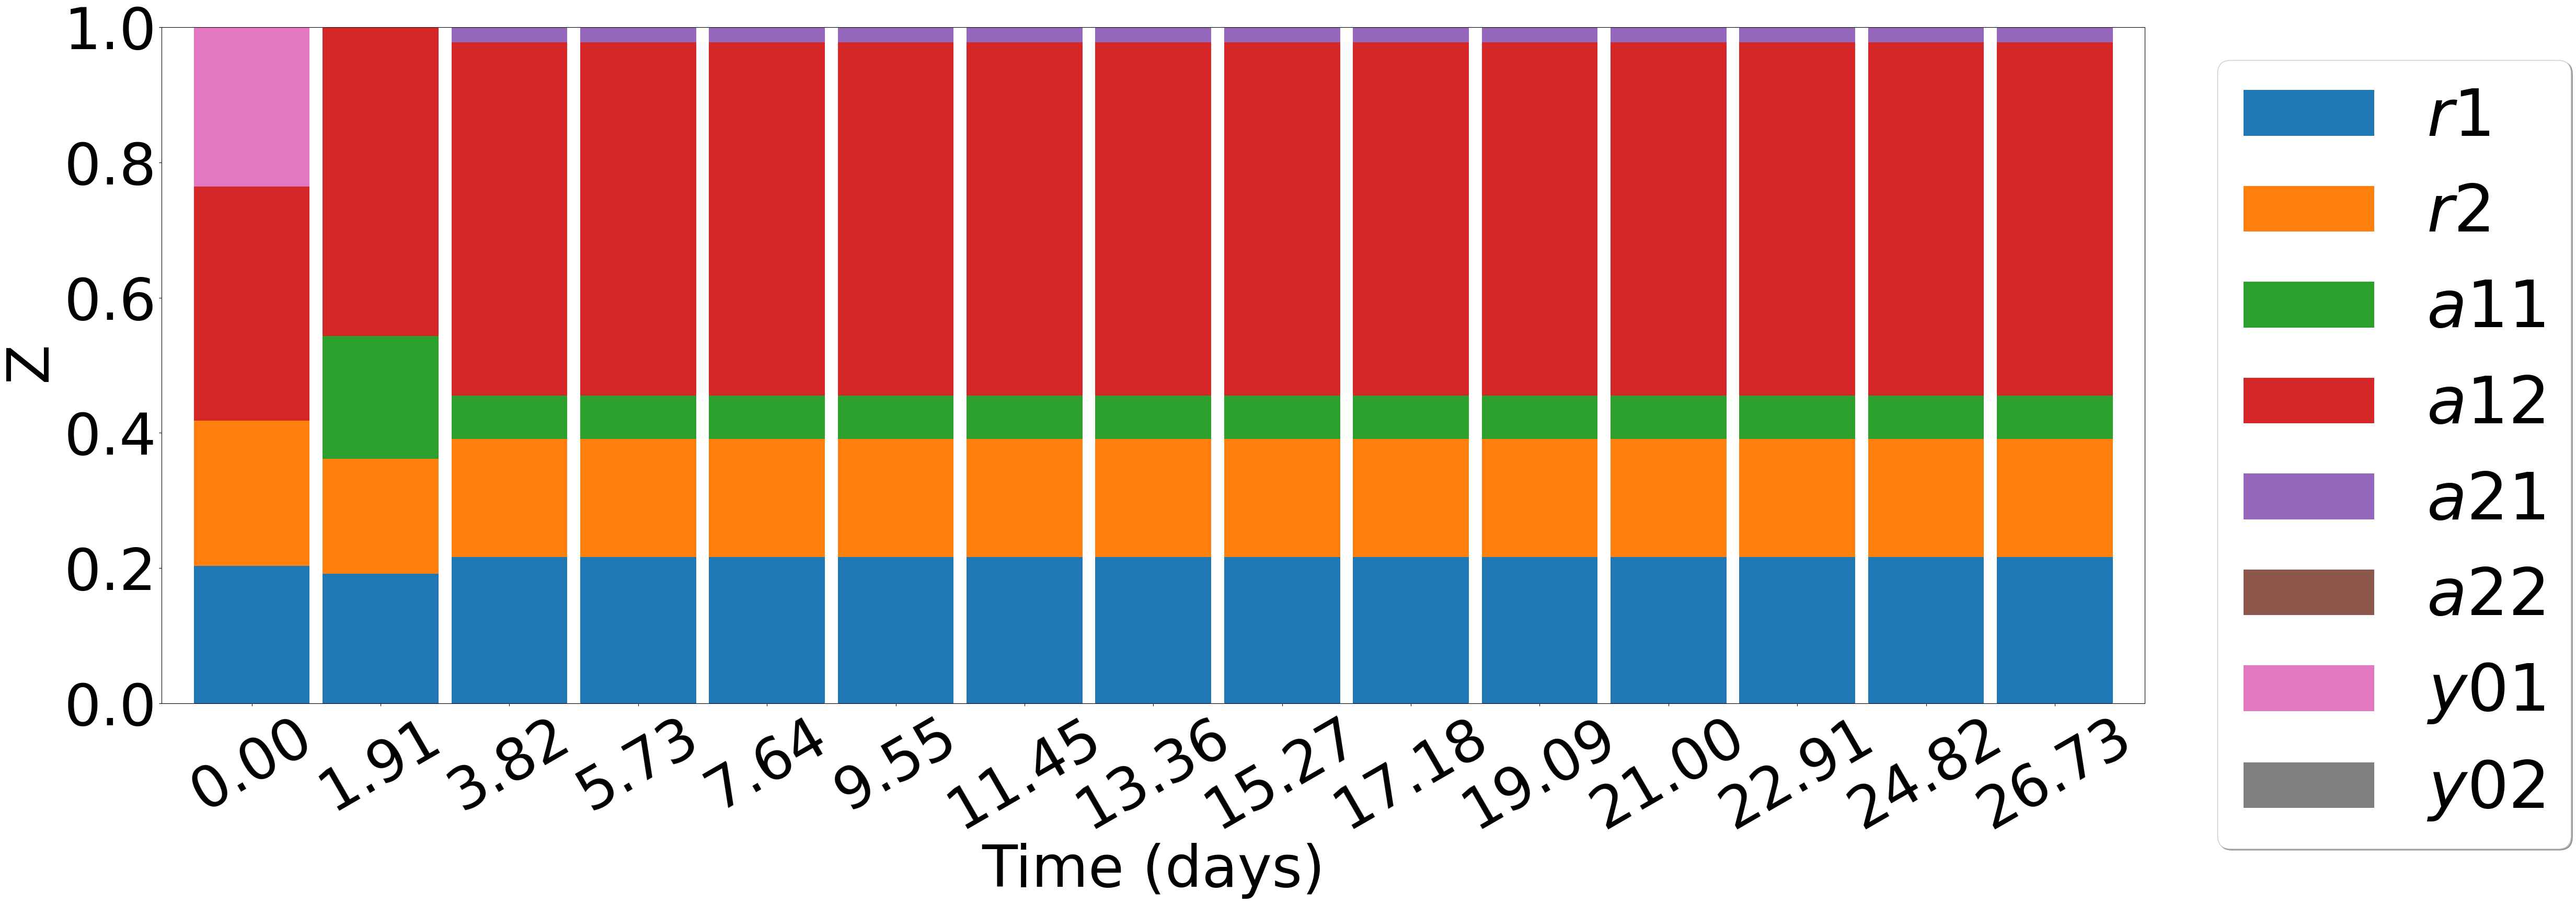

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 7
valid_time_lists_to_plot_zeta = valid_time_lists[::step_to_plot]
df_zetai[::step_to_plot].plot.bar(x='time', rot=30, width=0.9, figsize=(50, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_zeta[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 80), plt.ylabel("$\mathrm{Z}$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fancybox=True, shadow=True, fontsize=90) #ncol=len(problem_info['names']), 

plt.tight_layout()
plt.savefig("img/SA_frequency_CBHM.png", dpi=50)
plt.show()